# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
%%capture
!pip install flat-table

# 0. Import libraries and load Starbucks data

In [2]:
# standard libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import math, json , re, os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, HTML, display
from tqdm import tqdm
from os.path import exists
from joblib import dump, load
from pprint import pprint
import flat_table

# ML specific classes through sklearn
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer, confusion_matrix, plot_confusion_matrix

# jupyter magic to display plots directly in the notebook
%matplotlib inline

# use vector graphics format for nicer plots
%config Inline.Backend.figure_format = 'svg'

plt.style.use('seaborn')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Exploratory Analysis

#### Lets look at the data and check out inconsistencies

## 1.1 Profile Dataset

In [3]:
display(profile.head(), profile.isna().sum().to_frame().rename(columns={0:'Null count'}))

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


,Null count
gender,2175
age,0
id,0
became_member_on,0
income,2175


In [4]:
profile.query("age == 118")

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


#### We find there are null values in Gender (along with'O') and Income columns. As we can see above, age is 118 for all rows where null value is present in gender and income columns

profile size: 17000


,gender
M,8484
F,6129
O,212


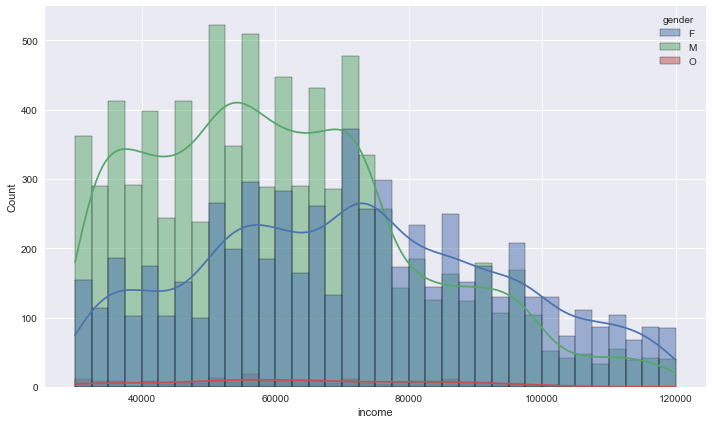

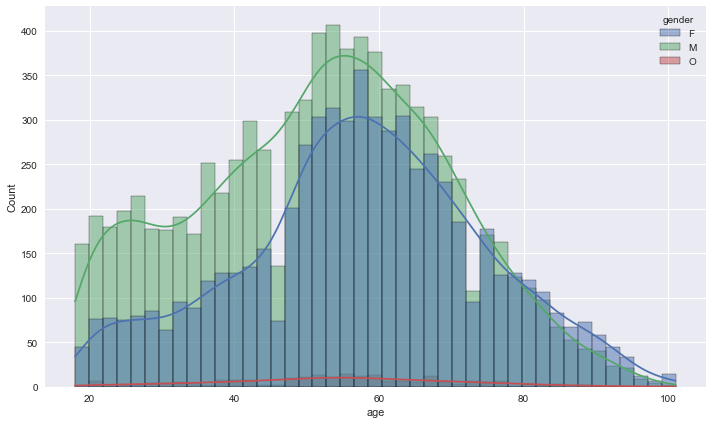

In [5]:
# let's first rename id to customer_id for more clarity
profile = profile.rename(columns={'id':'customer_id'})

# No. of users 
print('profile size: {}'.format(profile['customer_id'].unique().shape[0]))

# gender distribution
display(profile['gender'].value_counts().to_frame())

# income distribution by gender 
plt.figure(figsize=(10,6))
sns.histplot(data=profile, x="income", hue="gender", kde=True);
plt.tight_layout()
# plt.savefig('plots/profile_income_dist.svg')
plt.show()

# age distribution by gender
plt.figure(figsize=(10,6))
sns.histplot(data=profile, x="age", hue="gender", kde=True);
plt.tight_layout()
# plt.savefig('plots/profile_age_dist.svg')
plt.show()

In [6]:
# Convert "became_member_on" to standard python datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['became_member_in'] = profile['became_member_on'].apply(lambda x: x.year)
# Compute how long the user has been a member of the Starbucks app - let's say the anchor point is say 30-Sep-2020
profile['member_since_in_months'] = (pd.to_datetime("30-Sep-2020") - profile['became_member_on']).astype('timedelta64[M]').astype('int')

profile.head()

,gender,age,customer_id,became_member_on,income,became_member_in,member_since_in_months
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,43
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,38
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,26
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,40
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,37


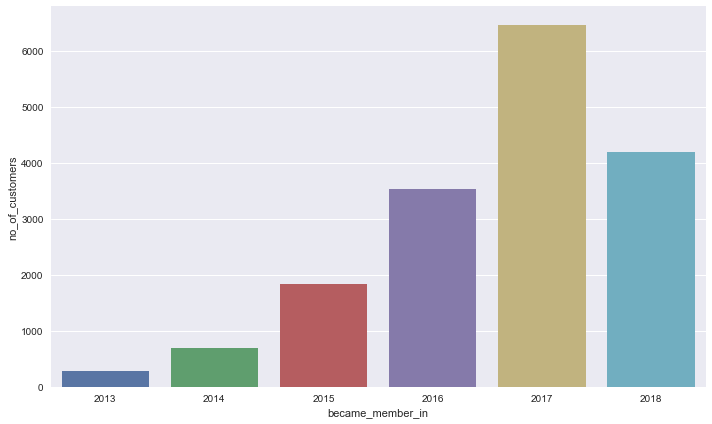

In [7]:
# "became member in" distribution by gender - how many customers are new and how many are long term members?
members_by_year = profile.groupby('became_member_in')['customer_id'].count().to_frame().rename(columns={'customer_id':'no_of_customers'})

plt.figure(figsize=(10,6))
sns.barplot(data = members_by_year, x=members_by_year.index, y='no_of_customers')
plt.tight_layout()
# plt.savefig('plots/profile_member_joined_dist.svg')
plt.show()

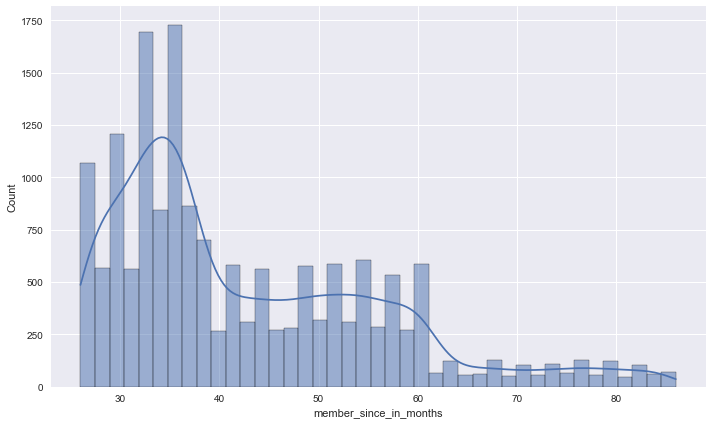

In [8]:
# "loyalty" distribution by gender
plt.figure(figsize=(10,6))
sns.histplot(data=profile, x="member_since_in_months", kde=True);
plt.tight_layout()
# plt.savefig('plots/profile_loyalty_dist.svg')
plt.show()

## 1.2 Portfolio Dataset

In [9]:
display(portfolio.head(), portfolio.isna().sum().to_frame().rename(columns={0:'Null count'}))

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


,Null count
reward,0
channels,0
difficulty,0
duration,0
offer_type,0
id,0


In [10]:
# let's first rename id to offer_id for more clarity
portfolio = portfolio.rename(columns={'id':'offer_id'})

# let's check the number of outstanding offers
portfolio_stats = portfolio.groupby('offer_type')['offer_id'].count().to_frame()
portfolio_stats.loc["total"] = portfolio_stats.sum(axis=0)
portfolio_stats

,offer_id
offer_type,
bogo,4
discount,4
informational,2
total,10


In [11]:
# we can see multiple channels through which offers have been delivered to users - let's check them
portfolio['channels'].explode().unique().tolist()

['email', 'mobile', 'social', 'web']

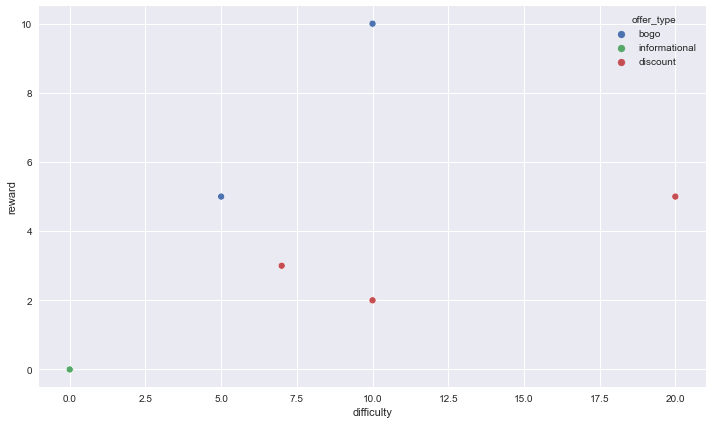

In [12]:
# we also see that each offer type has a reward and difficulty columns - would be interesting to see if you get more reward for spending more? :)
plt.figure(figsize=(10,6))
sns.scatterplot(data=portfolio, x="difficulty", y="reward", hue="offer_type")
plt.tight_layout()
# plt.savefig('plots/portfolio_reward_vs_difficulty.svg')
plt.show()

## 1.3 Transcript Dataset

In [13]:
display(transcript.head(), transcript.isna().sum().to_frame().rename(columns={0:'Null count'}))

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


,Null count
person,0
event,0
value,0
time,0


In [14]:
# let's first rename person to customer_id for more clarity
transcript = transcript.rename(columns={'person':'customer_id'})

In [15]:
# No. of users 
print('transcript size: {}'.format(transcript['customer_id'].unique().shape[0]))

transcript size: 17000


#### It looks as though the number of people in transcript are the same as the number of people in the profile dataset, so that is good news.

In [16]:
# what are the different types of values - we're mainly interested in the dictionary keys
dict_keys = [list(value.keys()) for value in transcript['value']]
# need to flatten list of lists that may be present - occurs when a dictionary has multiple keys
set([item for sublist in dict_keys for item in sublist])

{'amount', 'offer id', 'offer_id', 'reward'}

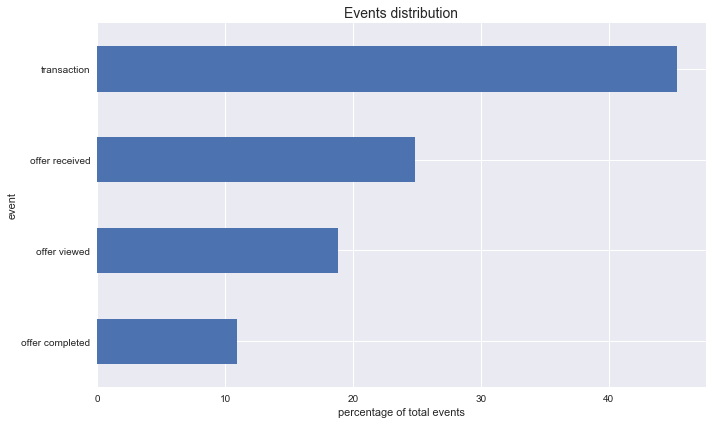

In [17]:
# event distribution
event_dist = transcript.groupby('event')['customer_id'].count().to_frame()
event_dist = event_dist.div(event_dist.sum(axis=0), axis=1).multiply(100)
ax = event_dist.rename(columns={'customer_id':'pct'}).sort_values(by='pct', ascending=True).plot(kind='barh', figsize=(10,6), legend=None);
plt.title('Events distribution', fontsize=14)
plt.xlabel('percentage of total events')
plt.tight_layout()
# plt.savefig('plots/transcript_event_dist.svg', dpi=300)
plt.show()

In [18]:
# let's expand values column and get keys as column headers and get rid of the dictionary
transcript = pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)
# there are duplicate offer id and offer_id columns - need to clean them up
transcript['offer_id'] = transcript['offer_id'].fillna(transcript['offer id'])
transcript = transcript.drop(columns=['offer id'])
transcript.head()

,customer_id,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [19]:
# check if no. of users in transcript is the same as in the profile dataset
users_in_transcript = list(transcript['customer_id'].unique())
users_in_profile = list(profile['customer_id'].unique())

in_transcript_but_not_in_profile  = [x for x in users_in_transcript if x not in set(users_in_profile)]
in_profile_but_not_in_transcript  = [x for x in users_in_profile if x not in set(users_in_transcript)]

print('Number of users in transcript but not in profile dataset: '+str(len(in_transcript_but_not_in_profile)))
print('Number of users in profile but not in transcript dataset: '+str(len(in_profile_but_not_in_transcript)))

Number of users in transcript but not in profile dataset: 0
Number of users in profile but not in transcript dataset: 0


#### Create a temporary dataset to analyze events and event_type to see which offers do the users prefer

In [20]:
temp = transcript.copy()
temp = temp.merge(portfolio[['offer_id','offer_type']], how='left', on='offer_id')
temp.head()

,customer_id,event,time,amount,offer_id,reward,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,bogo


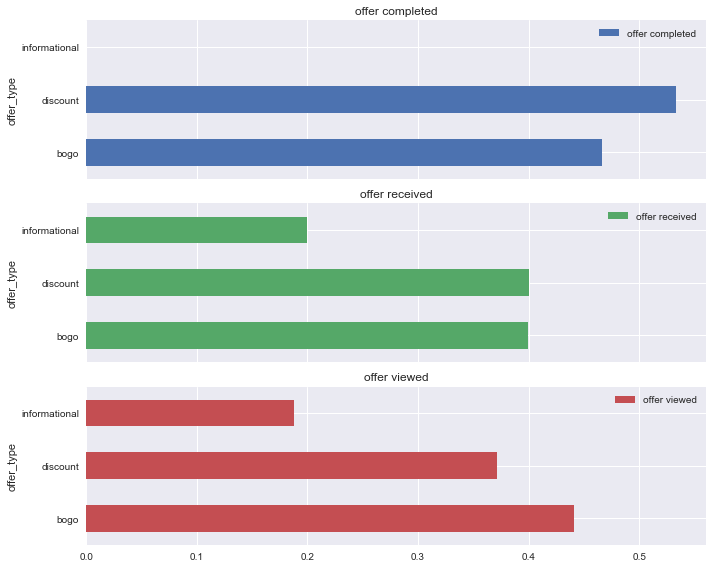

In [21]:
temp_group = temp.groupby(['event','offer_type'])['event'].count().to_frame().rename(columns={'event':'count'})

# get percentages event
temp_group['percentage'] = temp_group.div(temp_group.sum(level=0), level=0)
temp_group['percentage'].unstack(level=0).plot(kind='barh', subplots=True, figsize=(10,8));
plt.tight_layout()
# plt.savefig('plots/transcript_portfolio_offer_preference.svg', dpi=300)
plt.show()

# 2. Data cleaning and preprocessing for machine learning algorithms

#### Now lets clean up all three dataframes into a usable format and join them in one single dataframe

### 2.1 Clean profile dataset 

In [22]:
def clean_preprocess_profile(profile):
    """
    Takes the profile dataframe and cleans it by creating one-hot encodings as well as handling null values

    """
    # We can safely remove null values since they form a very small part of the dataset
    # Remove customers with null income data
    profile_copy = profile.copy()
    profile_copy = profile_copy.dropna(subset=['gender','income'])

    # Specifying age range
    min_age = np.int(np.floor(np.min(profile_copy['age'])/10)*10)
    max_age = np.int(np.ceil(np.max(profile_copy['age'])/10)*10)
    age_bins = range(min_age, max_age + 10, 10)
    
    profile_copy['age_range'] = pd.cut(x=profile_copy['age'], bins=age_bins, right=True).astype('str')
    # One-hot encode age_range column
    age_dummies = pd.get_dummies(profile_copy['age_range'])

    # No need to convert gender to a number, directly one-hot encode it - the order of number does not signify importance
    customer_gender_map = dict(zip(profile_copy['customer_id'], profile_copy['gender'])) 
    # one-hot encode gender to dummies since its a categorical feature
    gender_dummies = pd.get_dummies(profile_copy['gender'])
    
    # We will also not one-hot encode income range since its a continuous variable - keep original values as feature
    # the year that a customer became a member in is not uniformly distributed (6th cell) - potential customer differentiator
    # let's add dummies for that as well
    year_dummies = pd.get_dummies(profile_copy['became_member_in'])
    
    # concat the dummies to the profile dataset and drop the original columns
    cleaned_profile = (pd.concat([profile_copy, gender_dummies, age_dummies, year_dummies], axis=1, sort=False)
                         .drop(columns=['age','age_range','gender','became_member_on','became_member_in','member_since_in_months']))
    
    return cleaned_profile, customer_gender_map

In [23]:
cleaned_profile, customer_gender_map = clean_preprocess_profile(profile)
cleaned_profile.head()

,customer_id,income,F,M,O,"(10, 20]","(100, 110]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]","(80, 90]","(90, 100]",2013,2014,2015,2016,2017,2018
1,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
5,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [24]:
len(list(customer_gender_map.keys()))

14825

In [25]:
cleaned_profile.columns

Index(['customer_id',      'income',           'F',           'M',
                 'O',    '(10, 20]',  '(100, 110]',    '(20, 30]',
          '(30, 40]',    '(40, 50]',    '(50, 60]',    '(60, 70]',
          '(70, 80]',    '(80, 90]',   '(90, 100]',          2013,
                2014,          2015,          2016,          2017,
                2018],
      dtype='object')

### 2.2 Clean portfolio dataset 

In [26]:
def clean_preprocess_portfolio(portfolio):
    """
    Takes the portfolio dataframe and cleans it by creating one-hot encodings
    
    """
    # No null handling required since there are no NULL values
    # One-hot encode channels column - using sckit-learn module
    multi_label_binary = MultiLabelBinarizer()
    multi_label_binary.fit(portfolio['channels'])
    
    channels_dummies = pd.DataFrame(multi_label_binary.transform(portfolio['channels']), columns=multi_label_binary.classes_)
    
    # One-hot encode offer_type column
    offer_type_dummies = pd.get_dummies(portfolio['offer_type'])
    
    # that's it - concat now
    portfolio = pd.concat([portfolio, channels_dummies, offer_type_dummies], axis=1, sort=False) \
                  .drop(columns=['offer_type', 'channels'])
    
    return portfolio

In [27]:
cleaned_portfolio = clean_preprocess_portfolio(portfolio)
cleaned_portfolio.head()

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


### 2.3 Clean transcript dataset 

In [28]:
def clean_preprocess_transcript(transcript, profile):
    """ 
    Transforms the transcript dataframe and clean it by creating one-hot encodings 
    Also split the dataframe into seperate offers and transaction datasets
    
    """
    # we need to only keep users that are in the cleaned profile (after removal of nulls and age 118)
    # even though original datasets have the same number of customer ids
    transcript_copy = transcript.copy()
    transcript_copy = transcript_copy[transcript_copy['customer_id'].isin(list(profile['customer_id'].unique()))]
    
    # Convert time column from hours to days
    transcript_copy['time'] = transcript_copy['time'] / 24.0
    
    # let's first get dummies for events
    event_dummies = pd.get_dummies(transcript_copy['event'])
    event_dummies.columns = [col.replace(' ','_') for col in event_dummies.columns]

    # now concat to get final dataframe
    cleaned_transcript = pd.concat([transcript_copy, event_dummies], axis=1, sort=False).drop(columns=['event'])
    
    offer_cols = ['customer_id','offer_id','time','offer_completed','offer_received','offer_viewed']
    transac_cols = ['customer_id','time','amount','reward']
    cleaned_offer_dataset = cleaned_transcript.query("offer_completed==1 or offer_received==1 or offer_viewed==1")[offer_cols]
    cleaned_transaction_dataset = cleaned_transcript.query("transaction==1")[transac_cols]
    
    return cleaned_transcript, cleaned_offer_dataset, cleaned_transaction_dataset

In [29]:
cleaned_transcript, cleaned_offer_dataset, cleaned_transaction_dataset = clean_preprocess_transcript(transcript, cleaned_profile)
cleaned_transcript.head()

,customer_id,time,amount,offer_id,reward,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0


In [30]:
len(cleaned_transcript['customer_id'].unique().tolist())

14825

In [31]:
cleaned_offer_dataset.head()

,customer_id,offer_id,time,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0


In [32]:
# so, out of 17000 users, 2175 had null data for gender/income => so, 14825 users. Now, out of these, 5 had no offers but they still transacted.
# We'll remove these from our offer dataset since they do not add value
users_with_no_offers = cleaned_transcript[~cleaned_transcript['customer_id'].isin(list(cleaned_offer_dataset['customer_id'].unique()))]
users_with_no_offers.head()

print("Unique users with no offers, only transactions: "+str(len(users_with_no_offers['customer_id'].unique().tolist())))

Unique users with no offers, only transactions: 5


In [33]:
cleaned_transaction_dataset.head()

,customer_id,time,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,0.0,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97,NaN


# 3. Data preparation/Feature Engineering for model input

## Observations
#### What is an effective offer?
1. For BOGO and discount offers, an effective offer would be defined if the events are defined in this chronological order:
   **offer received > offer viewed > transaction > offer completed**
2. For Informational offer, the event chronology would be:
   **offer received > offer viewed > transaction**
   
#### What is not counted as an effective offer?
1. User recieved and viewed the offer but did not transact: **offer received > offer viewed** (no offer completed/transaction events)
2. User received offer but did not do anything: **offer received** (did not even view it)
3. Users who transacted w/o receiving an offer, after the offer is completed, before the offer is received or before the the offer is viewed. The different timelines can be summarized as:
    - **transaction**
    - **offer received > "do nothing"** (did not even view the offer)
    - **offer received > transaction > offer completed > offer viewed**
    - **transaction > offer received > offer completed > offer viewed**
    - **offer received > transaction > offer viewed > offer completed**
    - **offer received > transaction** (only applicable to informational offer)
    - **offer received > transaction > offer viewed** (only applicable to informational offer)
    
(3) can be summarized as - if an offer completed or transaction event occurs before an offer viewed event occurs.

### 3.1 Let's iterate through each customer id and offer_id to label the dataset (computationally intensive)

In [34]:
def construct_effective_offer_label(profile, portfolio, offers, transactions):
    # define the unique customer_ids to loop over
    customer_ids = offers['customer_id'].unique().tolist()
    events = ['offer_completed','offer_received','offer_viewed']
    
    all_offers_labeled = []
    for _user in tqdm(range(len(customer_ids))):
        # get customer_id from the list
        user_id = customer_ids[_user]
        
        # get profile data for the user
        user_profile = profile.query("customer_id == @user_id").drop(columns='customer_id').reset_index(drop=True)
        # get offer data for the user
        user_offers_data = offers.query("customer_id == @user_id").drop(columns='customer_id').reset_index(drop=True)
        # get transaction data for the user
        user_transactions_data = transactions.query("customer_id == @user_id").drop(columns='customer_id').reset_index(drop=True)
        
        offer_received = user_offers_data.query("offer_received == 1").drop(columns=events).reset_index(drop=True)
        offer_viewed = user_offers_data.query("offer_viewed == 1").drop(columns=events).reset_index(drop=True)
        offer_completed = user_offers_data.query("offer_completed == 1").drop(columns=events).reset_index(drop=True)
        
        # loop over each offer for the particular user
        all_offers_user = []
        for offer in range(len(offer_received)):
            # fetch offer id for the offer 
            offer_id = offer_received.iloc[offer]['offer_id']
            
            # extract offer data from portfolio
            offer_details = portfolio.query("offer_id == @offer_id").drop(columns=['offer_id']).reset_index(drop=True)
            
            # extract offer duration from offer row
            offer_duration = offer_details['duration'].values[0]

            # compute offer start and offer end times (in days)
            start_offer = offer_received.iloc[offer]['time']
            end_offer = start_offer + offer_duration
            
            # check if offer was viewed/completed and was transcated for the duration of the offer
            transaction_mask = (user_transactions_data['time'] >= start_offer) & (user_transactions_data['time'] <= end_offer)
            offer_transactions = user_transactions_data[transaction_mask]
            
            offer_viewed_mask = (offer_viewed['time'] >= start_offer) & (offer_viewed['time'] <= end_offer)
            offer_completed_mask = (offer_completed['time'] >= start_offer) & (offer_completed['time'] <= end_offer)
            offer_successful_mask = (offer_viewed_mask.sum() > 0) & (offer_completed_mask.sum() > 0)
            
            # make a dictionary that describes the current user offer
            offer_summary = {'effective_offer': int(offer_successful_mask), 'offer_id': offer_id, 'customer_id': user_id, 
                             'time': start_offer, 'total_amount_transacted_for_offer': offer_transactions['amount'].sum()}
            
            offer_summary_df = pd.DataFrame([offer_summary])
            # prepare to concat the features now from offer_details and user_offers_data
            offer_labeled = (pd.concat([offer_summary_df, offer_details, user_profile], axis=1, sort=False))
            
            all_offers_user.append(offer_labeled)
        
        # aggregate all offers for the user
        user_offers_labeled = pd.concat(all_offers_user)        
        
        all_offers_labeled.append(user_offers_labeled)
    
    # aggregate for all users/customer_ids
    all_offers_labeled_df = pd.concat(all_offers_labeled)
    
    return all_offers_labeled_df

In [35]:
%%time
if exists('data/labeled_dataset_with_effective_offer.pkl'):
    effective_offer_labeled_dataset = pd.read_pickle('data/labeled_dataset_with_effective_offer.pkl')
else:
    effective_offer_labeled_dataset = (construct_effective_offer_label(cleaned_profile, 
                                                                   cleaned_portfolio, 
                                                                   cleaned_offer_dataset, 
                                                                   cleaned_transaction_dataset))
    effective_offer_labeled_dataset.to_pickle('data/labeled_dataset_with_effective_offer.pkl')

CPU times: user 15.3 ms, sys: 9.06 ms, total: 24.4 ms
Wall time: 24.7 ms


In [36]:
effective_offer_labeled_dataset.head()

,effective_offer,offer_id,customer_id,time,total_amount_transacted_for_offer,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,income,F,M,O,"(10, 20]","(100, 110]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]","(80, 90]","(90, 100]",2013,2014,2015,2016,2017,2018
0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,5,5,7,1,1,0,1,1,0,0,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,0,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,7.0,49.39,0,0,3,1,1,1,0,0,0,1,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,1,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,10,10,7,1,1,1,0,1,0,0,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,1,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,21.0,48.28,5,5,5,1,1,1,1,1,0,0,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0.00,2,10,7,1,1,0,1,0,1,0,70000.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [37]:
# let's do a quick sanity check on the dataset to see if any nulls creeped in
effective_offer_labeled_dataset.isna().sum()

effective_offer                      0
offer_id                             0
customer_id                          0
time                                 0
total_amount_transacted_for_offer    0
reward                               0
difficulty                           0
duration                             0
email                                0
mobile                               0
social                               0
web                                  0
bogo                                 0
discount                             0
informational                        0
income                               0
F                                    0
M                                    0
O                                    0
(10, 20]                             0
(100, 110]                           0
(20, 30]                             0
(30, 40]                             0
(40, 50]                             0
(50, 60]                             0
(60, 70]                 

In [38]:
# let's check how many offers were sent out to users and how many were actually effective by gender
effective_offers = effective_offer_labeled_dataset.copy()

effective_offers = effective_offers[['offer_id', 'effective_offer', 'customer_id']]
effective_offers['gender'] = effective_offers['customer_id'].map(customer_gender_map)
effective_offers = effective_offers.groupby(['offer_id','gender']) \
                                   .agg({'effective_offer': 'sum','customer_id':'count'}) \
                                   .rename(columns={'effective_offer':'total_effective_offers','customer_id':'total_offers'})

effective_offers['pct_effective_offers'] = (effective_offers['total_effective_offers'] / effective_offers['total_offers'])*100

effective_offers

total_effective_offers  total_offers  \
offer_id                         gender                                         
0b1e1539f2cc45b7b9fa7c272da2e1d7 F                         1438          2801   
                                 M                         1578          3826   
                                 O                           62            99   
2298d6c36e964ae4a3e7e9706d1fb8c2 F                         2179          2718   
                                 M                         2595          3845   
                                 O                           67            92   
2906b810c7d4411798c6938adc9daaa5 F                         1449          2728   
                                 M                         1661          3815   
                                 O                           55            88   
3f207df678b143eea3cee63160fa8bed F                          240          2749   
                                 M                          268          3812   
                                 O                            6            96   
4d5c57ea9a6940dd891ad53e9dbe8da0 F                         1742          2737   
                                 M                         1623          3784   
                                 O                           45            72   
5a8bc65990b245e5a138643cd4eb9837 F                          172          2789   
                                 M                          229          3755   
                                 O                           16            99   
9b98b8c7a33c4b65b9aebfe6a799e6d9 F                         1508          2767   
                                 M                         1652          3817   
                                 O                           68           101   
ae264e3637204a6fb9bb56bc8210ddfd F                         1779          2750   
                                 M                         1814          3840   
                                 O                           59            93   
f19421c1d4aa40978ebb69ca19b0e20d F                         1868          2721   
                                 M                         2119          3767   
                                 O                           65            88   
fafdcd668e3743c1bb461111dcafc2a4 F                         2208          2696   
                                 M                         2734          3868   
                                 O                           66            88   

                                         pct_effective_offers  
offer_id                         gender                        
0b1e1539f2cc45b7b9fa7c272da2e1d7 F                  51.338808  
                                 M                  41.244119  
                                 O                  62.626263  
2298d6c36e964ae4a3e7e9706d1fb8c2 F                  80.169242  
                                 M                  67.490247  
                                 O                  72.826087  
2906b810c7d4411798c6938adc9daaa5 F                  53.115836  
                                 M                  43.538663  
                                 O                  62.500000  
3f207df678b143eea3cee63160fa8bed F                   8.730447  
                                 M                   7.030430  
                                 O                   6.250000  
4d5c57ea9a6940dd891ad53e9dbe8da0 F                  63.646328  
                                 M                  42.891121  
                                 O                  62.500000  
5a8bc65990b245e5a138643cd4eb9837 F                   6.167085  
                                 M                   6.098535  
                                 O                  16.161616  
9b98b8c7a33c4b65b9aebfe6a799e6d9 F                  54.499458  
                                 M                  43.280063  
                                 O      

In [39]:
# let's make the offer labels a bit more readable
offer_label_synthetic = []
for idx in range(0,len(list(set(effective_offers.index.get_level_values('offer_id')))),1):
    offer_label_synthetic.append("Offer ID "+str(idx+1))
    
offer_id_dict = dict(zip(list(set(effective_offers.index.get_level_values('offer_id'))),offer_label_synthetic))
effective_offers = effective_offers[['pct_effective_offers']].reset_index().replace({'offer_id':offer_id_dict}) \
                                                             .set_index('offer_id').sort_index().reset_index()
effective_offers.head()

,offer_id,gender,pct_effective_offers
0,Offer ID 1,M,7.030430
1,Offer ID 1,F,8.730447
2,Offer ID 1,O,6.250000
3,Offer ID 10,F,53.115836
4,Offer ID 10,M,43.538663


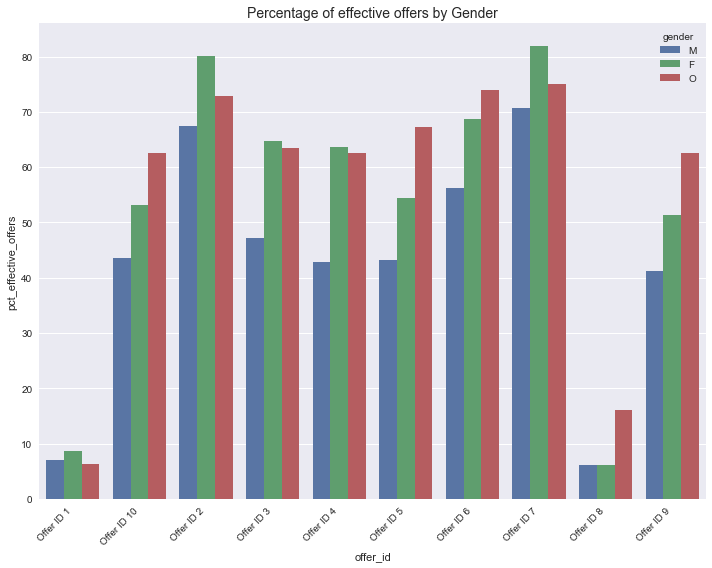

In [40]:
g = sns.catplot(data=effective_offers, x='offer_id', y='pct_effective_offers', hue='gender', kind='bar', legend_out=False)
g.fig.set_size_inches(10,8)
g.set_xticklabels(rotation=45, horizontalalignment='right').despine(left=True)
plt.title("Percentage of effective offers by Gender", fontsize=14)
plt.tight_layout()
plt.savefig('plots/labeled_dataset_pct_effective_offers.svg')
plt.show()

## 3.2 Feature Engineering/Data Transformation

#### Normalize Numerical Features


Our labeled dataset includes both numeric and one hot encoded categorical variables. We will apply minimum/maximum scaling to numeric variables to bring all numeric variables on one scale. This is done so that the size of numeric value does not result in model bias

In [41]:
final_dataset = effective_offer_labeled_dataset.copy()
# we'll drop columns/features which are not useful for the modeling part
columns_to_remove = ['total_amount_transacted_for_offer','time','offer_id','customer_id','informational']
final_dataset = final_dataset.drop(columns=columns_to_remove)
final_dataset.head()

,effective_offer,reward,difficulty,duration,email,mobile,social,web,bogo,discount,income,F,M,O,"(10, 20]","(100, 110]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]","(80, 90]","(90, 100]",2013,2014,2015,2016,2017,2018
0,1,5,5,7,1,1,0,1,1,0,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,0,0,0,3,1,1,1,0,0,0,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,1,10,10,7,1,1,1,0,1,0,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,1,5,5,5,1,1,1,1,1,0,100000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,0,2,10,7,1,1,0,1,0,1,70000.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [42]:
numeric_columns = ['reward','income','difficulty','duration']

target_label = 'effective_offer'

class_label = final_dataset.filter([target_label])
features = final_dataset.drop(columns=target_label) 

scaler = MinMaxScaler()
features[numeric_columns] = scaler.fit_transform(features[numeric_columns])
features_names = features.columns
features.head()

,reward,difficulty,duration,email,mobile,social,web,bogo,discount,income,F,M,O,"(10, 20]","(100, 110]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]","(80, 90]","(90, 100]",2013,2014,2015,2016,2017,2018
0,0.5,0.25,0.571429,1,1,0,1,1,0,0.777778,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,0.0,0.00,0.000000,1,1,1,0,0,0,0.777778,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,1.0,0.50,0.571429,1,1,1,0,1,0,0.777778,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,0.5,0.25,0.285714,1,1,1,1,1,0,0.777778,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,0.2,0.50,0.571429,1,1,0,1,0,1,0.444444,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [43]:
print("Number of total features: {}\n============================\n".format(len(features.columns)))

# Split the features dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, class_label, 
                                       test_size = 0.10, # 90/10 split between training/test
                                       random_state = 42, # the usual integer value that works as "seed" value for reproduce the same split on each run
                                       stratify = class_label)

# Display result after split
print("results of the split\n============================")
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

print("\nclass distribution\n============================")
print('y_train class distribution\n----------------------------')
print(y_train.value_counts(normalize=True))
print('\ny_test class distribution\n----------------------------')
print(y_test.value_counts(normalize=True))

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

Number of total features: 29

results of the split
Training set has 59850 samples.
Testing set has 6651 samples.

class distribution
y_train class distribution
----------------------------
effective_offer
0                  0.528354
1                  0.471646
dtype: float64

y_test class distribution
----------------------------
effective_offer
0                  0.528342
1                  0.471658
dtype: float64


# 4. Evaluating/training models for predictions

### 4.1 Benchmark model - Naive Predictor

A naive predictor assumes that all customer offers were successful

In [44]:
train_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
train_f1score = f1_score(y_train,np.ones(len(y_train)))

test_accuracy = accuracy_score(y_test,np.ones(len(y_test)))
test_f1score = f1_score(y_test,np.ones(len(y_test)))

naive_pred_perf = {}
naive_pred_perf['NaivePredictor'] = {}
naive_pred_perf['NaivePredictor']['train'] = {}
naive_pred_perf['NaivePredictor']['test'] = {}
naive_pred_perf['NaivePredictor']['train']['accuracy'] = train_accuracy
naive_pred_perf['NaivePredictor']['train']['f1score'] = train_f1score
naive_pred_perf['NaivePredictor']['test']['accuracy'] = test_accuracy
naive_pred_perf['NaivePredictor']['test']['f1score'] = test_f1score
                               
pprint(naive_pred_perf)

{'NaivePredictor': {'test': {'accuracy': 0.4716583972334987,
                             'f1score': 0.6409889660809155},
                    'train': {'accuracy': 0.4716457811194653,
                              'f1score': 0.6409773155612072}}}


In [45]:
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
scorer = make_scorer(fbeta_score, beta=0.5)

### 4.2 Logistic Regression

Perform Random Search Cross Validation on model hyperparameter space. Grid search is a brute force way of finding the optimal parameters because it train and test every possible combination. 

In [46]:
lr_model_path = os.path.join(model_dir, 'logistic_regression_model.joblib')

if exists(lr_model_path):
    # if model already exists
    lr_random = load(lr_model_path)
else:
    # instantiate a logistic regression classifer object
    lr_classifier = LogisticRegression(random_state=42, solver='liblinear')

    # grid dictionary
    grid_parameters = {'penalty': ['l1', 'l2'], 'C': [0.0001,0.001,0.01,0.1,1,10,100,1000]} # smaller C results in a stronger regularization
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    lr_random = RandomizedSearchCV(estimator = lr_classifier,
                                   param_distributions = grid_parameters,
                                   scoring = scorer,
                                   cv = cv,
                                   verbose = 2,
                                   random_state = 42,
                                   n_jobs = 4) # use 4 processors for parallel computation

    lr_random.fit(X_train, y_train)

    dump(lr_random, lr_model_path)

In [47]:
def model_peformance_statistics(classifier, x_train, y_train, x_test, y_test):
    best_classifier = classifier.best_estimator_
    
    classifier_name = str(best_classifier.__class__).replace("'>""",'').split('.')[-1]
    
    predict_y_train = best_classifier.predict(x_train)
    predict_y_test = best_classifier.predict(x_test)
    
    model_perf_stats = {}
    model_perf_stats[classifier_name] = {}
    model_perf_stats[classifier_name]['train'] = {}
    model_perf_stats[classifier_name]['test'] = {}
    model_perf_stats[classifier_name]['train']['accuracy'] = accuracy_score(y_train, predict_y_train)
    model_perf_stats[classifier_name]['train']['f1score'] = f1_score(y_train, predict_y_train)
    model_perf_stats[classifier_name]['test']['accuracy'] = accuracy_score(y_test, predict_y_test)
    model_perf_stats[classifier_name]['test']['f1score'] = f1_score(y_test, predict_y_test)
    
    return classifier.best_params_, model_perf_stats

In [48]:
lr_params, lr_perf = model_peformance_statistics(lr_random, X_train, y_train, X_test, y_test)
print("Logistic Regression best fit parameters:\n======================================")
pprint(lr_params)
print("\nModel Performance:\n======================================")
pprint(lr_perf)

Logistic Regression best fit parameters:
{'C': 10, 'penalty': 'l2'}

Model Performance:
{'LogisticRegression': {'test': {'accuracy': 0.7254548188242369,
                                 'f1score': 0.721391516631065},
                        'train': {'accuracy': 0.7219883040935673,
                                  'f1score': 0.7164016294250991}}}


### 4.3 Random Forest Classifier

In [49]:
rf_model_path = os.path.join(model_dir, 'random_forest_model.joblib')

if exists(rf_model_path):
    # if model already exists
    rf_random = load(rf_model_path)
else:
    # instantiate a random forest classifier obj
    rf_classifier = RandomForestClassifier(random_state = 42)

    # Number of trees in random forest - ideal range: log scale from 10 to 1,000.
    n_estimators =  [10, 100, 250, 400, 650, 1000] #[np.int(x) for x in np.logspace(1,3,15)]

    # Number of features to consider at every split
    max_features = ['log2', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.arange(3, 11)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # grid dictionary
    grid_parameters = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf}
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    rf_random = RandomizedSearchCV(estimator = rf_classifier,
                                   param_distributions = grid_parameters,
                                   scoring = scorer,
                                   n_iter = 50,
                                   cv = cv,
                                   verbose = 2,
                                   random_state = 42,
                                   n_jobs = -1) # use all processors for parallel computation

    rf_random.fit(X_train, y_train)
    
    dump(rf_random, rf_model_path)

In [50]:
rf_params, rf_perf = model_peformance_statistics(rf_random, X_train, y_train, X_test, y_test)
print("Random Forest Classifier best fit hyperparameters:\n======================================")
pprint(rf_params)
print("\nModel Performance:\n======================================")
pprint(rf_perf)

Random Forest Classifier best fit hyperparameters:
{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 400}

Model Performance:
{'RandomForestClassifier': {'test': {'accuracy': 0.7307171853856563,
                                     'f1score': 0.7231411346421395},
                            'train': {'accuracy': 0.7404511278195489,
                                      'f1score': 0.7332302936630603}}}


### 4.4 Gradient Boosting Classifier

In [51]:
gb_model_path = os.path.join(model_dir, 'gradient_boosting_model.joblib')

if exists(gb_model_path):
    # if model already exists
    gb_random = load(gb_model_path)
else:
    # instantiate a gradient boosting classifier obj
    gb_classifier = GradientBoostingClassifier(random_state = 42)
    
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # grid dictionary
    grid_parameters = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 100, 250, 400, 650, 1000], #[np.int(x) for x in np.logspace(1,3,15)]
                   'max_depth': [3, 7, 9],
                   'subsample': [0.5, 0.7, 1.0],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_samples_split}
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    gb_random = RandomizedSearchCV(estimator = gb_classifier,
                                   param_distributions = grid_parameters,
                                   scoring = scorer,
                                   n_iter = 50,
                                   cv = 3,
                                   verbose = 2,
                                   random_state = 42,
                                   n_jobs = -1) # use all processors for parallel computation

    gb_random.fit(X_train, y_train)

    dump(gb_random, gb_model_path)

In [52]:
gb_params, gb_perf = model_peformance_statistics(gb_random, X_train, y_train, X_test, y_test)
print("Gradient Boosting Classifier best fit hyperparameters:\n======================================")
pprint(gb_params)
print("\nModel Performance:\n======================================")
pprint(gb_perf)

Gradient Boosting Classifier best fit hyperparameters:
{'learning_rate': 0.001,
 'loss': 'exponential',
 'max_depth': 9,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 400,
 'subsample': 0.7}

Model Performance:
{'GradientBoostingClassifier': {'test': {'accuracy': 0.7280108254397835,
                                         'f1score': 0.6939604127897141},
                                'train': {'accuracy': 0.7383291562238931,
                                          'f1score': 0.7050825753723895}}}


### 4.5 Support Vector Machines (SVM)

In [53]:
svm_model_path = os.path.join(model_dir, 'support_vector_machines_model.joblib')

if exists(svm_model_path):
    # if model already exists
    svm_random = load(svm_model_path)
else:
    # instantiate a svm obj
    svm_classifier = SVC(random_state = 42)
    
    # grid dictionary
    grid_parameters = {'kernel': ['linear','poly', 'rbf', 'sigmoid'],
                       'C': [100, 10, 1.0, 0.1, 0.001],
                       'gamma': ['scale']}
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    svm_random = RandomizedSearchCV(estimator = svm_classifier,
                                   param_distributions = grid_parameters,
                                   scoring = scorer,
                                   n_iter = 20,
                                   cv = 3,
                                   verbose = 2,
                                   random_state = 42,
                                   n_jobs = -1) # use all processors for parallel computation

    svm_random.fit(X_train, y_train)

    dump(svm_random, svm_model_path)

In [54]:
svm_params, svm_perf = model_peformance_statistics(svm_random, X_train, y_train, X_test, y_test)
print("SVM best fit hyperparameters:\n======================================")
pprint(svm_params)
print("\nModel Performance:\n======================================")
pprint(svm_perf)

SVM best fit hyperparameters:
{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

Model Performance:
{'SVC': {'test': {'accuracy': 0.7274094121184784,
                  'f1score': 0.7156078431372549},
         'train': {'accuracy': 0.727702589807853,
                   'f1score': 0.7159564270152504}}}


### 4.6 K-Nearest Neighbors (KNN)

In [55]:
knn_model_path = os.path.join(model_dir, 'k_nearest_neighbors_model.joblib')

if exists(knn_model_path):
    # if model already exists
    knn_random = load(knn_model_path)
else:
    # instantiate a KNN obj
    knn_classifier = KNeighborsClassifier()
    
    # grid dictionary
    grid_parameters = {'n_neighbors': range(1, 21, 2),
                       'weights': ['uniform', 'distance'],
                       'metric': ['euclidean', 'manhattan', 'minkowski']}
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    knn_random = RandomizedSearchCV(estimator = knn_classifier,
                                   param_distributions = grid_parameters,
                                   scoring = scorer,
                                   n_iter = 50,
                                   cv = 3,
                                   verbose = 2,
                                   random_state = 42,
                                   n_jobs = -1) # use all processors for parallel computation

    knn_random.fit(X_train, y_train)

    dump(knn_random, knn_model_path)

In [56]:
knn_params, knn_perf = model_peformance_statistics(knn_random, X_train, y_train, X_test, y_test)
print("K-Nearest Neighbors best fit hyperparameters:\n======================================")
pprint(knn_params)
print("\nModel Performance:\n======================================")
pprint(knn_perf)

K-Nearest Neighbors best fit hyperparameters:
{'metric': 'minkowski', 'n_neighbors': 19, 'weights': 'uniform'}

Model Performance:
{'KNeighborsClassifier': {'test': {'accuracy': 0.7134265523981356,
                                   'f1score': 0.7016280525986225},
                          'train': {'accuracy': 0.7502756892230577,
                                    'f1score': 0.7378630559842853}}}


# 5. Model Performance Evaluation and Feature Importance Checks

## 5.1 Model Performance - on Accuracy and F1 Score

In [57]:
model_performance_dict = {**naive_pred_perf,**lr_perf,**rf_perf,**gb_perf,**svm_perf,**knn_perf}

In [58]:
model_performance_stats = flat_table.normalize(pd.DataFrame(model_performance_dict).T) \
                                                          .rename(columns={'index':'Machine Learning Algorithms',
                                                                           'train.f1score':'Train - F1 Score',
                                                                           'train.accuracy':'Train - Accuracy',
                                                                           'test.f1score':'Test - F1 Score',
                                                                           'test.accuracy':'Test - Accuracy'}) \
                                                          .set_index('Machine Learning Algorithms')
order_of_columns = ['Train - Accuracy','Train - F1 Score','Test - Accuracy','Test - F1 Score']
model_performance_stats = model_performance_stats[order_of_columns].sort_values(by='Test - Accuracy',ascending=True)
model_performance_stats

,Train - Accuracy,Train - F1 Score,Test - Accuracy,Test - F1 Score
Machine Learning Algorithms,,,,
NaivePredictor,0.471646,0.640977,0.471658,0.640989
KNeighborsClassifier,0.750276,0.737863,0.713427,0.701628
LogisticRegression,0.721988,0.716402,0.725455,0.721392
SVC,0.727703,0.715956,0.727409,0.715608
GradientBoostingClassifier,0.738329,0.705083,0.728011,0.693960
RandomForestClassifier,0.740451,0.733230,0.730717,0.723141


In [59]:
def evaluate_feature_importance(estimator):
    best_classifier = estimator.best_estimator_
    classifier_name = str(best_classifier.__class__).replace("'>""",'').split('.')[-1]
    
    title = classifier_name+' Estimated Feature Importance'
    
    if classifier_name == 'LogisticRegression':
        # We can look at the coefficients in the coef_ attribute of the fitted Logistic Regression model to see which features are most important.
        # For LogisticRegression, all transform is doing is looking at which coefficients are highest in absolute value.
        # Source: https://stackoverflow.com/questions/24255723/sklearn-logistic-regression-important-features
        classifier_feature_importance = np.abs(best_classifier.coef_)
    else:
        classifier_feature_importance = best_classifier.feature_importances_
    
    classifier_feature_importance = classifier_feature_importance / np.sum(classifier_feature_importance)
    
    # each model has different formats - some even have features that are nested (list of lists)
    if classifier_name == 'LogisticRegression':
        classifier_feature_importance = classifier_feature_importance.tolist()
        classifier_feature_importance = [item for sublist in classifier_feature_importance for item in sublist]
    elif classifier_name == 'RandomForestClassifier':
        classifier_feature_importance = classifier_feature_importance.tolist()
    elif classifier_name == 'GradientBoostingClassifier':
        pass
    
    feature_importance = pd.DataFrame(list(zip(features_names.tolist(),classifier_feature_importance)), \
                                      columns=['feature_name', 'classifier_importance']) \
                            .sort_values('classifier_importance', ascending = False) \
                            .reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x = 'classifier_importance',
                y = 'feature_name',
                data = feature_importance)
    plt.xlabel('Relative Importance of feature for classifier')
    plt.ylabel('Feature Name')
    plt.title(title)
    plt.tight_layout()
    plt.savefig('plots/'+title.lower().replace(' ','_')+'.svg')

## 5.2 Evaluate feature importance for all models (except naive of course)

Note: Feature Importance for fitted SVM classifier can be extract using the same method we used for Logistic Regression - 
Features whith highest importance are the ones with coefficients from the coef_ attribute that are highest in absolute value
However, it only works for SVM classifiers with linear kernel - but our best fitted model uses a 'rbf' kernel.
For other kernels, it is not possible because data is transformed by the kernel method to another space, which is not related to input space.
Source: 
    1. https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
    2. https://stackoverflow.com/questions/21260691/scikits-learn-how-to-obtain-features-weight

Also, feature importance is not defined for the KNN Classification algorithm. There is no easy way to compute the features responsible for a classification for a KNN fitted model. A hacky, brute force method can work in the following steps -
1. Evaluate the model accuracy based on the original dataset
2. For each feature in the dataset:
    1. Make a copy of the dataset
    2. Randomly shuffle the current target feature
    3. Evaluate the model accuracy based on the dataset with the shuffled feature
    4. Compute the difference in the accuracies - this is the feature importance, where higher is better

More info here - https://github.com/scikit-learn/scikit-learn/issues/8898

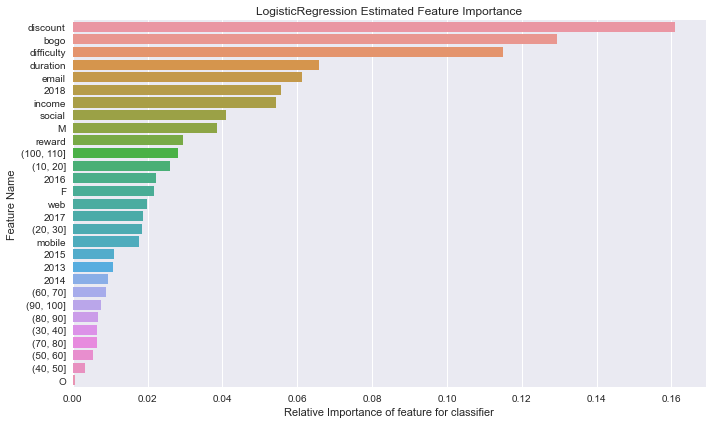

In [60]:
evaluate_feature_importance(lr_random)

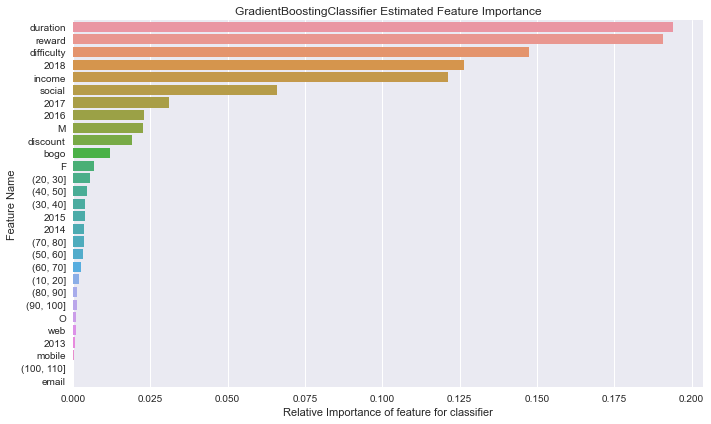

In [61]:
evaluate_feature_importance(gb_random)

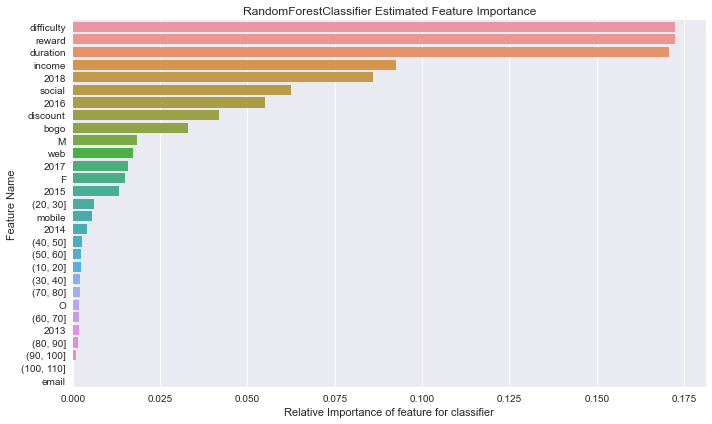

In [62]:
evaluate_feature_importance(rf_random)

## 5.3 Check confusion matrix

In [63]:
class_label_map = {0:'ineffective_offer', 1:'effective_offer'}
_classes = lr_random.best_estimator_.classes_.tolist()
mapped_classes = [class_label_map.get(l) for l in _classes]

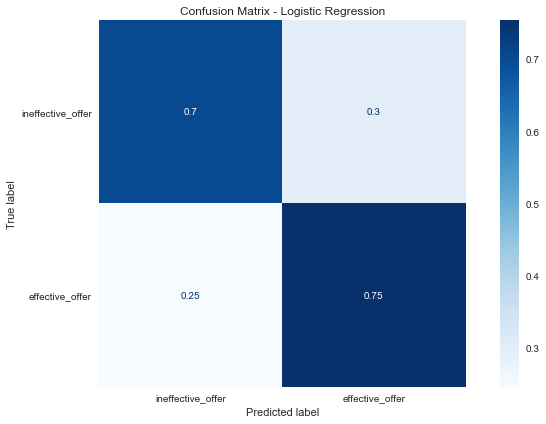

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
disp = plot_confusion_matrix(lr_random.best_estimator_, X_test, y_test, ax = ax, display_labels = mapped_classes, cmap = plt.cm.Blues,normalize = 'true')
disp.ax_.set_title('Confusion Matrix - Logistic Regression')
disp.ax_.grid(False)
plt.tight_layout()
plt.savefig('plots/confusion_matrix_logistic_regression.svg')

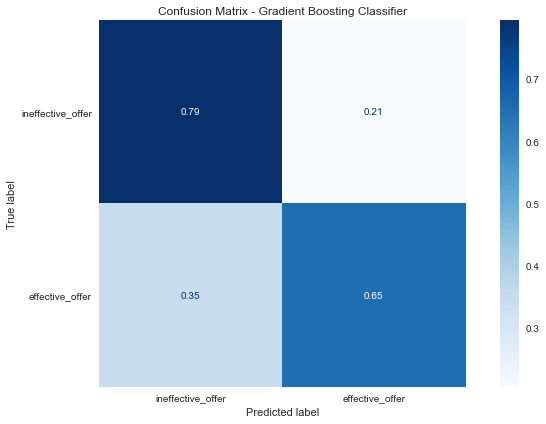

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))
disp = plot_confusion_matrix(gb_random.best_estimator_, X_test, y_test, ax = ax, display_labels = mapped_classes, cmap = plt.cm.Blues,normalize = 'true')
disp.ax_.set_title('Confusion Matrix - Gradient Boosting Classifier')
disp.ax_.grid(False)
plt.tight_layout()
plt.savefig('plots/confusion_matrix_gradient_boosting_classifier.svg')

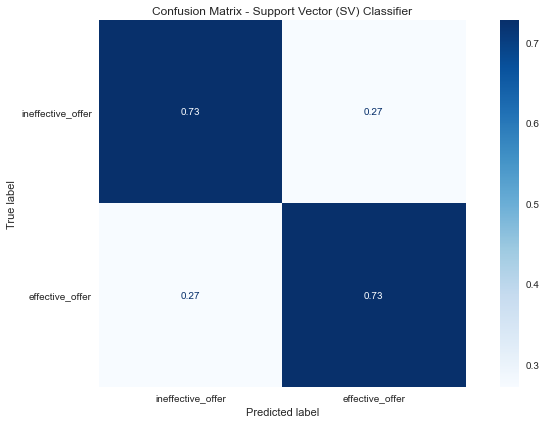

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
disp = plot_confusion_matrix(svm_random.best_estimator_, X_test, y_test, ax = ax, display_labels = mapped_classes, cmap = plt.cm.Blues,normalize = 'true')
disp.ax_.set_title('Confusion Matrix - Support Vector (SV) Classifier')
disp.ax_.grid(False)
plt.tight_layout()
plt.savefig('plots/confusion_matrix_support_vector_classifier.svg')

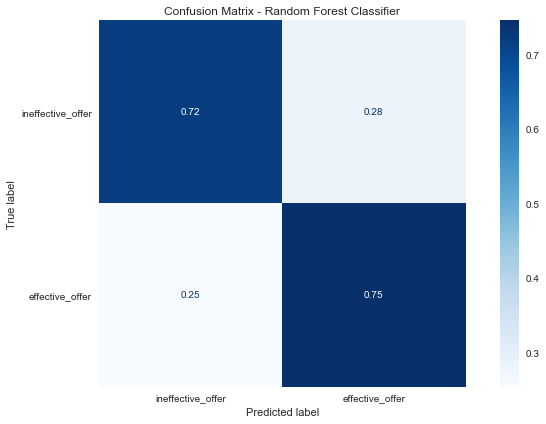

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))
disp = plot_confusion_matrix(rf_random.best_estimator_, X_test, y_test, ax = ax, display_labels = mapped_classes, cmap = plt.cm.Blues,normalize = 'true')
disp.ax_.set_title('Confusion Matrix - Random Forest Classifier')
disp.ax_.grid(False)
plt.tight_layout()
plt.savefig('plots/confusion_matrix_random_forest_classifier.svg')

# 6. Conclusion and Future Improvements

## 6.1 Analysing the results:

As we can see from the table in cell 56, in terms of both accuracy and F1 score, the Random Forest model has the best performance, albeit with a narrow margin over the other models, with KNN model performing best on the training dataset but fails to have a high accuracy over the test dataset.

We also performed a random search for the best fit hperparameters from a set of values so that we select the best performing parameters for each model. Even then, as you can see, we had a very narrow band of accuracy figures for each model - ranging from 72% to 74%. We know from other examples over the internet that the ensemble methods like Random Forest and Gradient Boosting show a very good performance over the other models.

This means that model tuning might not help much here, so we should look into improving the feature selection of the model, i.e. removing sparse features.

The results would indicate that Random Forest and Logistic Regression model have done the best at not misclassifying negative events as positive (meaning, misclassifying people on which offers are ineffective, as people on which offers would be effective).Gradient Boosting has the highest rate of misclassifying negative events as positive - however, it also has the lowest rate of misclassifying positive events as negative (from the confusion matrix). It (Gradient Boosting) also performs worse than Random Forest, which needs a bit more digging.

**Why Gradient Boosting has a worse accuracy/performance than Random Forest?**:\
Conceptually, both random forest and gradient boosting models are a combination of multiple decision trees. A random forest classifier randomly samples the training data with replacement to construct a set of decision trees that are combined using majority voting. In contrast, gradient boosting iteratively constructs a set of decision trees with the goal of reducing the number of misclassified training data samples from the previous iteration. A consequence of these model construction strategies is that the depth of decision trees generated during random forest model training are typically greater than gradient boosting weak learner depth to minimize model variance. Typically, gradient boosting performs better than a random forest classifier. However, gradient boosting may overfit the training data and requires additional effort to tune. A random forest classifier is less prone to overfitting because it constructs decision trees from random training data samples. Also, a random forest classifier's hyperparameters are easier to optimize (Source: https://www.quora.com/How-can-the-performance-of-a-Gradient-Boosting-Machine-be-worse-than-Random-Forests)

## 6.2 Conclusion:

All our models except Gradient Boositing are predicting the positive case (i.e. where an offer is effective) more accurately compared to predicting the negative cases (i.e. where an offer is ineffective), which is expected given the uneven classes. We are not much concerned with the misclassification cases since we don't mind sending people more offers than they would have liked; we would rather not miss anyone on which an offer would have been effective.

Given the analysis, we would select Random Forest as the best model to use.

We also look at important features for each algorithm - I have detailed parts where the important features can't be extracted due to technical limitations along with their source. "Feature importance" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric.

A random forest classifier is an example of a model that estimates feature importance during training. The analysis suggests that the top five features based on their importance for an effective offer are:

1. Offer difficulty (how much money a customer must spend to complete an offer) 
2. Offer reward
2. Offer duration
4. Customer income  
5. Whether a customer created an account on the Starbucks rewards app in 2018  

Since the top three features are associated with an customer offer, it may be possible to improve the performance of a random forest model by creating features that describe an offer's success rate as a function of offer difficulty, duration, and reward.
These additional features should provide a random forest classifier the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers.

We can also extract features by their relative importance for other models as shown in the analysis section 5.1

## 6.3 Future Improvements:

1. Feature engineering step - To improve model performance, we can try to drop some dummy variables/one-hot encoded features and see how it will affect the model performance.

    There is also an ongoing debate on the use of one hot encoding when using tree and regression models. For regression classification models (e.g. logistic regression), we should typically remove one level of the variable in order to prevent multicollinearity between variables. Typically, we should not run into this issue with tree-based models like random forest or gradient boosting.

    However, there is some debate as to whether one should do it or not. According to some articles (like here: https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/), it is generally not advisable to encode categorical variables as they would generate sparse matrices. The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.

    A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

2. Introduce Polynomial features - 
A low accuracy score for the models is likely due to the model underfitting more likely since we have very sparse features, we can try to transform the features into polynomial form (using PolynomialFeatures from sklean.pre_processing module) to further might improve model performance.

3. Add more data 
More data with a better distribution of effective/ineffective offers would have helped achieve a higher accuracy, as is the case with most machine learning algorithms.